In [3]:
import findspark

In [4]:
import pyspark

In [5]:
spark = pyspark.sql.SparkSession.builder.master('local').getOrCreate()

In [6]:
linesDF = spark.read \
        .format('csv') \
        .option('encoding', 'EUC-kr') \
        .option('header', 'False') \
        .option('sep', '\n') \
        .load('/home/tteon/바탕화면/MisCurriculum.txt')

In [5]:
linesDF.take(3)

[Row(_c0='현대경영과기업가정신[(구)경영학원론]'),
 Row(_c0='(Contemporary Business and Entrepreurship)'),
 Row(_c0='자유자본주의 체제하에서의 기업경영과 관련된 전반적 개념을 연구한다. 구체적으로 경영환경을 포함하여 경영활동의 계획, 집행 및 통제기법과 그 밖에 개인 및 집단행동, 조직구조 등과 관련된 기초 원리를 연구한다. ')]

In [7]:
import re

In [8]:
# transformation lines to RDD
linesRDD = linesDF.rdd

In [9]:
wcRDD = linesRDD.map(lambda line: line[0]) \
        .flatMap(lambda line : re.split('\\W+', line)) \
        .filter(lambda word : len(word)>0) \
        .map(lambda word : (word,1)) \
        .reduceByKey(lambda v, w : v+w) \
        .sortBy(lambda vw : vw[1], False) \

In [12]:
# transformation RDD to DF
wcDF = spark.createDataFrame(wcRDD)

In [13]:
wcDF.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: long (nullable = true)



In [14]:
wcDF.show(3)

+--------+---+
|      _1| _2|
+--------+---+
|      및| 41|
|학습한다| 15|
|Business| 14|
+--------+---+
only showing top 3 rows



In [15]:
import pyspark.sql.functions as F

In [18]:
wcDFnamed = wcDF.withColumnRenamed('_1', 'words')\
                 .withColumnRenamed('_2', 'freq')

In [20]:
wcDFnamed.printSchema()

root
 |-- words: string (nullable = true)
 |-- freq: long (nullable = true)



In [21]:
wcDFnamed.show(3)

+--------+----+
|   words|freq|
+--------+----+
|      및|  41|
|학습한다|  15|
|Business|  14|
+--------+----+
only showing top 3 rows



In [22]:
wcDFlength = wcDFnamed.withColumn('wordLen', F.length('words'))

In [23]:
wcDFlength.show(3)

+--------+----+-------+
|   words|freq|wordLen|
+--------+----+-------+
|      및|  41|      1|
|학습한다|  15|      4|
|Business|  14|      8|
+--------+----+-------+
only showing top 3 rows



In [26]:
wcDFlength.select(F.col('wordLen')).show(3)

+-------+
|wordLen|
+-------+
|      1|
|      4|
|      8|
+-------+
only showing top 3 rows



In [27]:
wcDFlength.select(wcDFlength.words).show(2)

+--------+
|   words|
+--------+
|      및|
|학습한다|
+--------+
only showing top 2 rows



In [28]:
wcDFlength.select('words').show(2)

+--------+
|   words|
+--------+
|      및|
|학습한다|
+--------+
only showing top 2 rows



In [30]:
wcDFlength.filter(F.col('wordLen') <= 1).show()

+-----+----+-------+
|words|freq|wordLen|
+-----+----+-------+
|   및|  41|      1|
|   수|  11|      1|
|   본|   8|      1|
|   등|   8|      1|
|   그|   3|      1|
|   이|   3|      1|
|   함|   3|      1|
|   의|   2|      1|
|   내|   2|      1|
|   구|   1|      1|
|   신|   1|      1|
|    I|   1|      1|
|    R|   1|      1|
|   더|   1|      1|
|   후|   1|      1|
|   팀|   1|      1|
|   각|   1|      1|
|   할|   1|      1|
|   로|   1|      1|
|   롤|   1|      1|
+-----+----+-------+
only showing top 20 rows



In [31]:
wcDFlength.filter(wcDFlength.wordLen <= 1).show()

+-----+----+-------+
|words|freq|wordLen|
+-----+----+-------+
|   및|  41|      1|
|   수|  11|      1|
|   본|   8|      1|
|   등|   8|      1|
|   그|   3|      1|
|   이|   3|      1|
|   함|   3|      1|
|   의|   2|      1|
|   내|   2|      1|
|   구|   1|      1|
|   신|   1|      1|
|    I|   1|      1|
|    R|   1|      1|
|   더|   1|      1|
|   후|   1|      1|
|   팀|   1|      1|
|   각|   1|      1|
|   할|   1|      1|
|   로|   1|      1|
|   롤|   1|      1|
+-----+----+-------+
only showing top 20 rows



In [44]:
wcDFlength.filter(wcDFlength.wordLen >= 1).show()

+----------+----+-------+
|     words|freq|wordLen|
+----------+----+-------+
|        및|  41|      1|
|  학습한다|  15|      4|
|  Business|  14|      8|
|      등을|  13|      2|
|      대한|  12|      2|
|      분석|  11|      2|
|        수|  11|      1|
|      이를|  11|      2|
|Management|  11|     10|
|  공부한다|  10|      4|
|    다양한|   9|      3|
|      위해|   9|      2|
|      한다|   9|      2|
|        IT|   9|      2|
|       and|   8|      3|
|        본|   8|      1|
|  목적으로|   8|      4|
|    이론을|   8|      3|
|        등|   8|      1|
|    디지털|   8|      3|
+----------+----+-------+
only showing top 20 rows



In [40]:
# agg function and show average using 'F.avg'
wordLengthFrequency = wcDFlength\
                     .groupby(F.col('wordLen'))\
                     .agg(F.count(F.col('freq')), F.avg(F.col('freq')))\
                     .orderBy(F.col('wordLen'))

In [41]:
wordLengthFrequency.show()

+-------+-----------+------------------+
|wordLen|count(freq)|         avg(freq)|
+-------+-----------+------------------+
|      1|         23| 4.130434782608695|
|      2|        197|2.1319796954314723|
|      3|        308|1.4545454545454546|
|      4|        216|1.4953703703703705|
|      5|        128|         1.2109375|
|      6|         53| 1.320754716981132|
|      7|         31|1.1935483870967742|
|      8|         22|1.9090909090909092|
|      9|         13|1.2307692307692308|
|     10|         15|1.7333333333333334|
|     11|          8|             1.625|
|     12|          6|1.1666666666666667|
|     13|          4|               1.0|
|     14|          2|               1.0|
+-------+-----------+------------------+



In [42]:
# plus argument 'F.sum'
wordLengthFrequency2 = wcDFlength\
                     .groupby(F.col('wordLen'))\
                     .agg(F.count(F.col('freq')), F.avg(F.col('freq')), F.sum(F.col('freq')))\
                     .orderBy(F.col('wordLen'))

In [43]:
wordLengthFrequency2.show()

+-------+-----------+------------------+---------+
|wordLen|count(freq)|         avg(freq)|sum(freq)|
+-------+-----------+------------------+---------+
|      1|         23| 4.130434782608695|       95|
|      2|        197|2.1319796954314723|      420|
|      3|        308|1.4545454545454546|      448|
|      4|        216|1.4953703703703705|      323|
|      5|        128|         1.2109375|      155|
|      6|         53| 1.320754716981132|       70|
|      7|         31|1.1935483870967742|       37|
|      8|         22|1.9090909090909092|       42|
|      9|         13|1.2307692307692308|       16|
|     10|         15|1.7333333333333334|       26|
|     11|          8|             1.625|       13|
|     12|          6|1.1666666666666667|        7|
|     13|          4|               1.0|        4|
|     14|          2|               1.0|        2|
+-------+-----------+------------------+---------+



In [8]:
top20Words=linesRDD.map(lambda line: line[0]) \
        .flatMap(lambda line : re.split('\\W+', line)) \
        .filter(lambda word : len(word)>0) \
        .map(lambda word : (word,1)) \
        .reduceByKey(lambda v, w : v+w) \
        .sortBy(lambda vw : vw[1], False) \
        .take(20)

In [9]:
top20Words

[('및', 41),
 ('학습한다', 15),
 ('Business', 14),
 ('등을', 13),
 ('대한', 12),
 ('분석', 11),
 ('수', 11),
 ('이를', 11),
 ('Management', 11),
 ('공부한다', 10),
 ('다양한', 9),
 ('위해', 9),
 ('한다', 9),
 ('IT', 9),
 ('and', 8),
 ('본', 8),
 ('목적으로', 8),
 ('이론을', 8),
 ('등', 8),
 ('디지털', 8)]

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
x = []
y = []

In [12]:
for (w , c) in top20Words:
    x.append(w)
    y.append(c)

In [13]:
from matplotlib import font_manager
fontpath = '/home/tteon/바탕화면/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=fontpath)

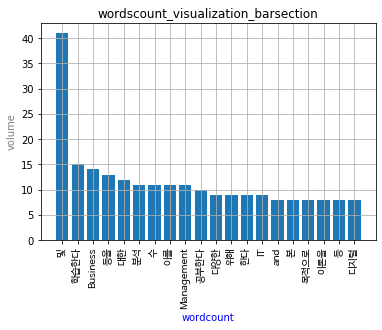

In [17]:
plt.bar(x,y)
plt.title('wordscount_visualization_barsection')
plt.xlabel('wordcount', color='blue')
plt.ylabel('volume' , color='gray')
plt.grid(True)
plt.xticks(rotation='vertical', fontproperties=fontprop)
plt.show()

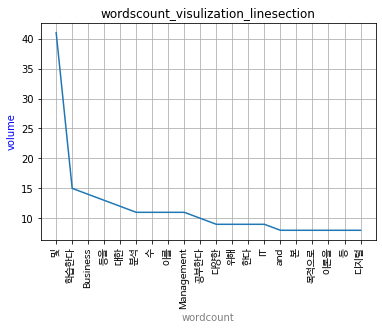

In [18]:
plt.plot(x,y)
plt.title('wordscount_visulization_linesection')
plt.xlabel('wordcount', color= 'gray')
plt.ylabel('volume' , color = 'blue')
plt.grid(True)
plt.xticks(rotation='vertical', fontproperties=fontprop)
plt.show()

In [19]:
linesDF_E = spark.read \
        .format('csv') \
        .option('header' , False) \
        .option('sep', '\n') \
        .load('/home/tteon/바탕화면/t_bbe.csv')

In [20]:
linesDF_E.take(5)

[Row(_c0='field,field,field,field,field'),
 Row(_c0='"01001001","1","1","1","At the first God made the heaven and the earth."'),
 Row(_c0='"01001002","1","1","2","And the earth was waste and without form; and it was dark on the face of the deep: and the Spirit of God was moving on the face of the waters."'),
 Row(_c0='"01001003","1","1","3","And God said, Let there be light: and there was light."'),
 Row(_c0='"01001004","1","1","4","And God, looking on the light, saw that it was good: and God made a division between the light and the dark,"')]

In [21]:
linesRDD_E = linesDF_E.rdd

In [22]:
top20Words_E=linesRDD_E.map(lambda line: line[0]) \
            .flatMap(lambda line : re.split('\\W+', line)) \
            .filter(lambda word : len(word)>0) \
            .map(lambda word : (word,1)) \
            .reduceByKey(lambda v, w : v+w) \
            .sortBy(lambda vw : vw[1], False) \
            .take(20)

In [23]:
top20Words_E

[('the', 63800),
 ('of', 37714),
 ('and', 33405),
 ('to', 26327),
 ('in', 14782),
 ('you', 12231),
 ('And', 11577),
 ('will', 10596),
 ('a', 10436),
 ('for', 10327),
 ('is', 10127),
 ('his', 9257),
 ('be', 8972),
 ('he', 8500),
 ('I', 7811),
 ('your', 7655),
 ('Lord', 7633),
 ('on', 6890),
 ('have', 6890),
 ('him', 6119)]

In [24]:
a = []
b = []

In [25]:
for (w , c) in top20Words_E:
    a.append(w)
    b.append(c)

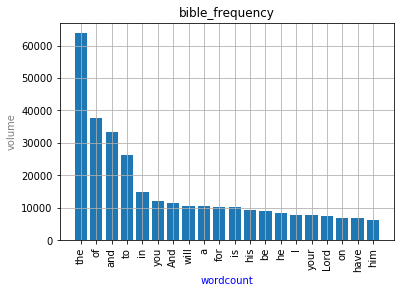

In [26]:
plt.bar(a,b)
plt.title('bible_frequency')
plt.xlabel('wordcount', color='blue')
plt.ylabel('volume' , color='gray')
plt.grid(True)
plt.xticks(rotation='vertical')
plt.show()

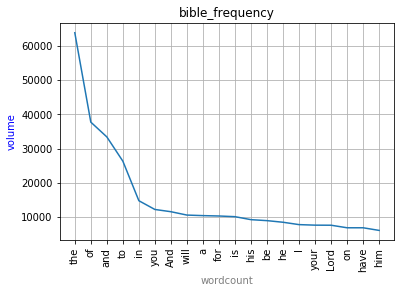

In [27]:
plt.plot(a,b)
plt.title('bible_frequency')
plt.xlabel('wordcount', color= 'gray')
plt.ylabel('volume' , color = 'blue')
plt.grid(True)
plt.xticks(rotation='vertical')
plt.show()